<h1><center>ICT for Smart Mobility</center></h1>

<center><font size="5">Exercise – Transport modelling - 2nd part </font></center>
<center><font size="5">Trip generation model of demand with KDE </font></center>



In this second part of the practical activity, you will create a demand model for trip generation in continuous space.

With KDE, you do NOT need to choose an appropriate zoning system.  The demand model should generalize and you will perform calibration and validation process.

In [1]:
import pandas as pd
df=pd.read_csv("Amsterdam_dataset.csv")

In [2]:
df

,Unnamed: 0,start_longitude,start_latitude,end_longitude,end_latitude,start_longitude_utm,start_latitude_utm,end_longitude_utm,end_latitude_utm,hour,daytype
0,7860,4.87345,52.33396,4.82726,52.35371,119982.797780,483016.349361,116851.530361,485237.087955,23,weekday
1,7872,4.90472,52.37038,4.91088,52.34494,122141.094886,487053.891014,122542.006910,484220.588956,23,weekday
2,7887,4.92591,52.36526,4.92612,52.35110,123580.569820,486474.827223,123584.850648,484899.252532,23,weekday
3,7854,4.87818,52.39087,4.88443,52.37641,120349.660072,489346.036596,120763.943156,487734.199761,23,weekday
4,7861,4.93046,52.33535,4.90276,52.35757,123869.504307,483144.993367,121998.086446,485629.503238,23,weekday
...,...,...,...,...,...,...,...,...,...,...,...
3649,575334,4.88705,52.36311,4.84528,52.38648,120932.135664,486253.167987,118106.464532,488873.832576,23,weekday
3650,575332,4.86997,52.36838,4.85935,52.36600,119772.934718,486847.688238,119047.722853,486588.098133,23,weekday
3651,575343,4.88375,52.36534,4.93667,52.37119,120709.083198,486502.840335,124317.543982,487130.008302,23,weekday
3652,575329,4.84560,52.38111,4.86470,52.36538,118123.783770,488276.187663,119411.610806,486516.474729,23,weekday


##
## STEP A – KDE for trip generation

    • Implement a simple KDE with Gaussian Kernel and arbitrary h or use the KernelDensity model from sklearn  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html
    • Fit this model to the data
    • Obtain the model for P(O) and P(D)


In this solution I will use the already implemented model

* from sklearn.neighbors import KernelDensity


In [3]:
from sklearn.neighbors import KernelDensity
import numpy as np

 - Obtain the model for P(O) - origin trips

In [4]:
X_origin=df[["start_longitude","start_latitude"]]

### Note

In the remainder of this solution, we are fitting the distribution purely on the coordinates in EPSG:4326. Since we are using a KDE model with a single smoothing parameter h, the two dimensions should be in the same unit of measure. Here we are working with latitude and longitude in Amsterdam, where a movemement of a car of 0.01 degrees in latitude does not correspond to a movement of 0.01 degrees in longitude. Hence, applying the method to UTM coordinates coverted to meters, will solve this issue and would lead to more correct results.

For problems for which different dimensions have different meaning, other more complex KDE models exists, where you can define a matrix H of smoothing parameters (many h), one for each dimension and one for each pairs of dimensions. These are called multivariate KDE.
Reference: https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation

We fit a KDE model with gaussian kernel and bandwidth equal to 0.05

In [5]:
kde_origin = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X_origin)

Now we have a model (kde_origin) that is a probability distribution over 2 dimensions (longitude and latitude). 

We can sample from our models. Let's sample 4 new origin points (couples of coordinates)

In [6]:
new_samples_origin=kde_origin.sample(4)
new_samples_origin

array([[ 4.86851213, 52.34064453],
       [ 4.83813778, 52.42739385],
       [ 4.84074057, 52.28555535],
       [ 4.86971684, 52.27071916]])

 - Obtain the model for P(D) - destination trips

In [7]:
X_destination=df[["end_longitude","end_latitude"]]

In [8]:
kde_destination = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X_destination)

    • Show the distributions P(O) and P(D) of the trip generation model on a map

We can measure the loglikelihood of the sample, i.e., their probability in the obtained density 

Let's first measure the loglikelihood of the first 3 samples in our data

In [9]:
log_density = kde_origin.score_samples(X_origin[:3])
log_density

array([3.73152427, 3.9133054 , 3.76248838])

In [10]:
#Here I am finding the min logitude, max longitude, min latitude and max latitude observed as origin/destination
#EXACTLY AS IN THE PREVIOUS SET OF EXERCISES

import numpy as np
import math

min_lon=min(df["start_longitude"].min(),df["end_longitude"].min())
max_lon=max(df["start_longitude"].max(),df["end_longitude"].max())
min_lat=min(df["start_latitude"].min(),df["end_latitude"].min())
max_lat=max(df["start_latitude"].max(),df["end_latitude"].max())

Now create a grid of points to evaluate the density on

In [11]:
#grid size, the smaller it is, the larger the number of points in the grid
grid_size=0.001
# x coordinates of the grid cells
xgrid = np.arange(min_lon, max_lon, grid_size)
# y coordinates of the grid cells
ygrid = np.arange(min_lat, max_lat, grid_size)
X, Y = np.meshgrid(xgrid, ygrid)
xy = np.vstack([X.ravel(), Y.ravel()]).T

xy contains now all the points in the 2D grid for which we want to estimate the density

In [12]:
#Estimate the density
Z = np.exp(kde_origin.score_samples(xy))
Z = Z.reshape(X.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


Now create a contour plot given the density Z over the grid of points XY

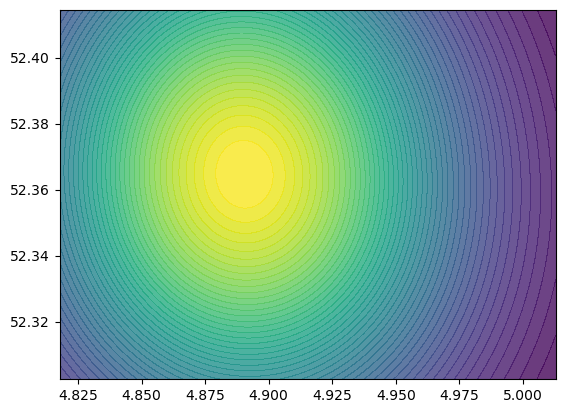

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
# plot contours of the density
levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)
plt.show()

Let's now plot the same contour plot over a map of Amsterdam

In [14]:
import folium
import geojsoncontour

In [15]:
# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)

m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m

Repeat the same for DESTINATION density

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


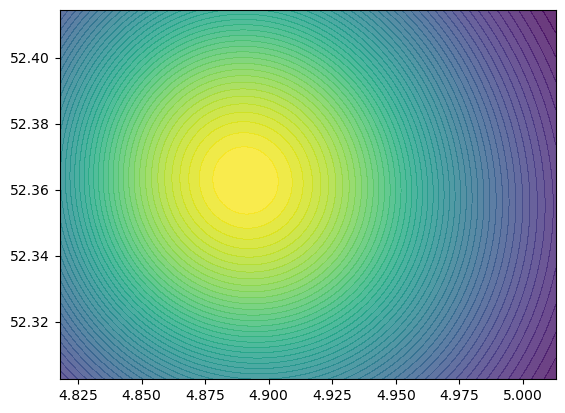

In [18]:
#Estimate the density
Z = np.exp(kde_destination.score_samples(xy))
Z = Z.reshape(X.shape)

levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)

# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)



In [19]:
m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m

##
## STEP B – Calibration of trip generation – finding bandwidth h
          
    • Evaluate the total log likelihood metric to be maximized: 1/N sum_(samples s) log(P(s)). You can also use score_samples of KernelDensity class of sklearn


Let's now measure the total likelihood of all the samples in our data.

Let's do it in two equivalent ways:

In [20]:
#option 1
#total average log likelhiood
tot_score_origin_1=1/len(X_origin) *kde_origin.score(X_origin)
tot_score_origin_1

3.7545165520600743

In [21]:
#option 2
#total average log likelhiood
tot_score_origin_2=1/len(X_origin) *kde_origin.score_samples(X_origin).sum()
tot_score_origin_2

3.7545165520600743

Let's compute the total average loglikelihood also for the destination model (only with option 1):

In [22]:
#total average log likelhiood
tot_score_destination=1/len(X_destination) *kde_destination.score(X_destination)
tot_score_destination

3.498448788089132

    • Calibrate the bandwidth h in order to maximize loglikelihood (go back to STEP A and recompute the trip generation model with different h)
    • What is a good value for h? What is the corresponding loglikelihood?

In [23]:
#define a list of bandwidth h to try - we define them logarithmically spaced 
#this is equal to h_list=[0.00001,0.0001, 0.001, 0.01, 0.1,1]
h_list= np.logspace(-5, 0, num=6)

#define lists to save results of loglikelihood
logLikelihoodOrigin_list=[]
logLikelihoodDestination_list=[]

for h in h_list:
    kde_origin = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_origin)
    tot_score_origin=1/len(X_origin) *kde_origin.score(X_origin)
    logLikelihoodOrigin_list.append(tot_score_origin)
    
    kde_destination = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_destination)
    tot_score_destination=1/len(X_destination) *kde_destination.score(X_destination)
    logLikelihoodDestination_list.append(tot_score_destination)

In [24]:
logLikelihoodOrigin_list

[13.019597331109312,
 8.863476846413526,
 5.767891251001125,
 4.895674250561456,
 2.649651139279914,
 -1.839137966918694]

In [25]:
logLikelihoodDestination_list

[13.043072011526657,
 8.952850722954087,
 5.753914993410924,
 4.507312098343849,
 2.5547915734995,
 -1.8402486813953938]

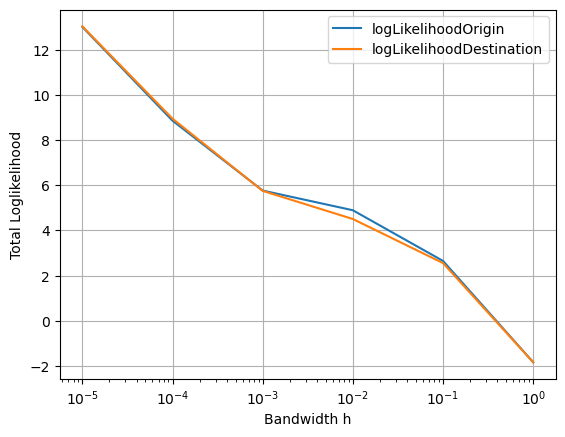

In [26]:
import matplotlib.pyplot as plt
plt.plot(h_list,logLikelihoodOrigin_list, label='logLikelihoodOrigin' )
plt.plot(h_list,logLikelihoodDestination_list, label='logLikelihoodDestination' )
plt.xlabel("Bandwidth h")
plt.ylabel("Total Loglikelihood")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

By considering all the data: the smaller the bandwidth, the best is the fit! This is true, because we are just overfitting the data

##
## STEP C – Validation of trip generation – finding bandwidth h

    • Divide the sample dataset into random training and validation samples and fit the KDE models (origin and destination) to the training data



In [29]:
from sklearn.model_selection import train_test_split
X_train_origin, X_validation_origin = train_test_split(X_origin, test_size=0.33, shuffle=True)
X_train_destination, X_validation_destination = train_test_split(X_destination, test_size=0.33, shuffle=True)

In [30]:
kde_train_origin = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_origin)
kde_train_destination = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_destination)

    • Evaluate the total log likelihood of the training and validation


In [31]:
#Loglikelihood for origin train
tot_score_train_origin=1/len(X_train_origin) *kde_train_origin.score(X_train_origin)
tot_score_train_origin


-1.839108915928161

In [32]:
#Loglikelihood for destination train
tot_score_train_destination=1/len(X_train_destination) *kde_train_destination.score(X_train_destination)
tot_score_train_destination

-1.8403214398054215

    • Calibrate the bandwidth h as in STEP B, but now on the TRAINING in order to maximize loglikelihood on the VALIDATION 
    • What are the differences with respect to step B?


In [33]:
#define a list of bandwidth h to try - we define them logarithmically spaced 
#this is equal to h_list=[0.00001,0.0001, 0.001, 0.01, 0.1,1]
h_list= np.logspace(-5, 0, num=6)

#define lists to save results of loglikelihood
logLikelihoodOrigin_train_list=[]
logLikelihoodDestination_train_list=[]
model_origin_list=[] #list to save the obtained KDE models
logLikelihoodOrigin_validation_list=[]
logLikelihoodDestination_validation_list=[]
model_destination_list=[] #list to save the obtained KDE models

for h in h_list:
    
    kde_train_origin = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_origin)
    tot_score_train_origin=1/len(X_train_origin) *kde_train_origin.score(X_train_origin)
    logLikelihoodOrigin_train_list.append(tot_score_train_origin)
    tot_score_validation_origin=1/len(X_validation_origin) *kde_train_origin.score(X_validation_origin)
    logLikelihoodOrigin_validation_list.append(tot_score_validation_origin)
    model_origin_list.append(kde_train_origin)
    
    
    kde_train_destination = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_destination)
    tot_score_train_destination=1/len(X_train_destination) *kde_train_destination.score(X_train_destination)
    logLikelihoodDestination_train_list.append(tot_score_train_destination)
    tot_score_validation_destination=1/len(X_validation_destination) *kde_train_destination.score(X_validation_destination)
    logLikelihoodDestination_validation_list.append(tot_score_validation_destination)
    model_destination_list.append(kde_train_destination)


In [34]:
print(logLikelihoodOrigin_train_list)
print(logLikelihoodDestination_train_list)
print(logLikelihoodOrigin_validation_list)
print(logLikelihoodDestination_validation_list)

[13.408802720200098, 9.142121019577022, 5.847719385945931, 4.928656653744443, 2.652350464946349, -1.839108915928161]
[13.424965342169784, 9.224378784592963, 5.8207559687374095, 4.503865733391146, 2.549121964429913, -1.8403214398054215]
[-4986.467290002949, -37.541775775930354, 5.3404960349764, 4.834875581712986, 2.64821613550523, -1.8391535512498185]
[-4267.696228525157, -29.241448465480804, 5.367401884187206, 4.5115133009795, 2.5584350409422303, -1.840212017315093]


In [35]:
h_list

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

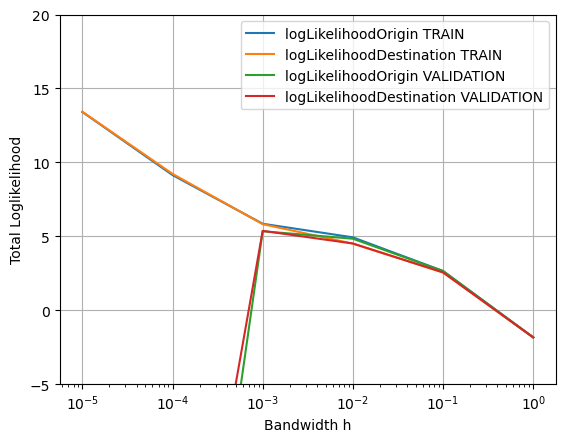

In [36]:
import matplotlib.pyplot as plt
plt.plot(h_list,logLikelihoodOrigin_train_list, label='logLikelihoodOrigin TRAIN' )
plt.plot(h_list,logLikelihoodDestination_train_list, label='logLikelihoodDestination TRAIN' )
plt.plot(h_list,logLikelihoodOrigin_validation_list, label='logLikelihoodOrigin VALIDATION' )
plt.plot(h_list,logLikelihoodDestination_validation_list, label='logLikelihoodDestination VALIDATION' )
plt.xlabel("Bandwidth h")
plt.ylabel("Total Loglikelihood")
plt.xscale("log")
plt.ylim(-5,20)
plt.legend()
plt.grid()
plt.show()

Here we can clearly see that 10^-3=0.001 represents the best value on the validation among the ones we tried. Reducing it will clearly produce under-smoothing (overfitting), while larger h will produce over-smoothing 

### Note

You could add more points to the curve to find out the exact maximum. Since the curve is convex, it is enough to search around the local maximum, for example with the bisection method

    • Show the distributions P(O) and P(D) of the trip generation model on a map

In [37]:
model_origin_list

[KernelDensity(bandwidth=1e-05),
 KernelDensity(bandwidth=0.0001),
 KernelDensity(bandwidth=0.001),
 KernelDensity(bandwidth=0.01),
 KernelDensity(bandwidth=0.1),
 KernelDensity()]

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


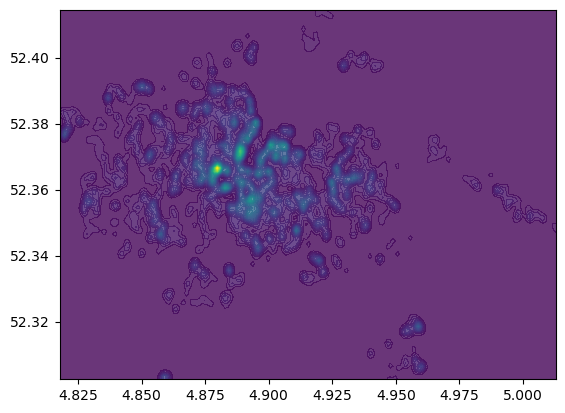

In [38]:
#Estimate the density
Z = np.exp(model_origin_list[2].score_samples(xy))
Z = Z.reshape(X.shape)

levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)

# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)

m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


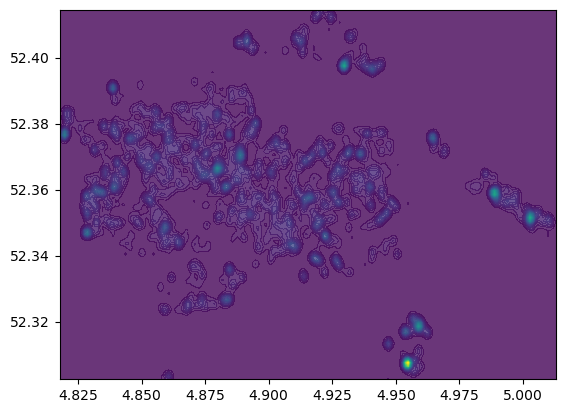

In [39]:
#Estimate the density
Z = np.exp(model_destination_list[2].score_samples(xy))
Z = Z.reshape(X.shape)

levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)

# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)

m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m